<div style="padding: 10px; border-radius: 5px;">
    <h2>Tabla de Contenidos</h2>
    <ul>
        <li>
            <h3><a href="#punto-1">Punto 1</a></h3>
            <ul>
                <li><a href="#punto-1-1">Punto 1.1</a></li>
                <li><a href="#punto-1-2">Punto 1.2</a></li>
                <li><a href="#punto-1-3">Punto 1.3</a></li>
            </ul>
        </li>
        <li>
            <h3><a href="#punto-2">Punto 2</a></h3>
            <ul>
                <li><a href="#punto-2-1">Punto 2.1</a></li>
                <li><a href="#punto-2-2">Punto 2.2</a></li>
                <li><a href="#punto-2-3">Punto 2.3</a></li>
            </ul>
        </li>
        <li>
            <h3><a href="#punto-3">Punto 3</a></h3>
            <ul>
                <li><a href="#punto-3-1">Punto 3.1</a></li>
                <li><a href="#punto-3-2">Punto 3.2</a></li>
                <li><a href="#punto-3-3">Punto 3.3</a></li>
            </ul>
        </li>
    </ul>
</div>

<h1 id="punto-1">Punto 1</h1>

## Punto 1.1 <a id="punto-1-1"></a>

In [28]:
import numpy as np
import pandas as pd


df = pd.read_csv(r"../data/raw/casas_dev.csv") 

df.sample(5, random_state=42)


,area,area_units,is_house,has_pool,age,price,lat,lon,rooms
70,872.0,sqft,0,0,11.0,630.0,40.718433,-74.008699,2.0
827,1076.0,sqft,0,0,7.0,772.0,40.707037,-73.998823,3.0
231,137.0,m2,0,0,10.0,214.0,-34.550223,-58.391268,4.0
588,775.0,sqft,1,1,10.0,751.0,40.726223,-74.043929,2.0
39,154.0,m2,1,0,16.0,273.0,-34.563525,-58.347365,4.0


In [29]:

df.describe(include='all')


,area,area_units,is_house,has_pool,age,price,lat,lon,rooms
count,900.000000,900,900.000000,900.000000,770.000000,900.000000,900.000000,900.000000,828.000000
unique,NaN,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,NaN,m2,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,NaN,463,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,533.598889,NaN,0.418889,0.144444,10.212987,466.197778,1.966225,-65.967203,2.737923
std,502.318230,NaN,0.493651,0.351735,4.773010,347.122903,37.661269,7.813671,0.948574
min,40.000000,NaN,0.000000,0.000000,1.000000,65.000000,-34.686302,-74.058238,1.000000
25%,93.000000,NaN,0.000000,0.000000,6.250000,178.750000,-34.605803,-74.005566,2.000000
50%,164.500000,NaN,0.000000,0.000000,11.000000,323.500000,-34.529704,-58.459293,3.000000
75%,980.000000,NaN,1.000000,0.000000,14.000000,712.500000,40.709819,-58.379873,3.000000


Algo que es particular resaltar es que la feature ```area_units``` no tiene sentido que se mantenga. Podemos realizar una conversión y eliminar está feature.

Convertimos la feature ```sqft``` a ```m2``` y eliminamos la columna ```area_units```

In [30]:
df.loc[df['area_units'] == 'sqft', 'area'] = df['area'] * 0.092903
df.loc[df['area_units'] == 'sqft', 'area_units'] = 'm2'

df = df.drop('area_units', axis=1)

df.describe(include='all')

,area,is_house,has_pool,age,price,lat,lon,rooms
count,900.000000,900.000000,900.000000,770.000000,900.000000,900.000000,900.000000,828.000000
mean,94.794747,0.418889,0.144444,10.212987,466.197778,1.966225,-65.967203,2.737923
std,30.220560,0.493651,0.351735,4.773010,347.122903,37.661269,7.813671,0.948574
min,40.000000,0.000000,0.000000,1.000000,65.000000,-34.686302,-74.058238,1.000000
25%,74.000000,0.000000,0.000000,6.250000,178.750000,-34.605803,-74.005566,2.000000
50%,92.995903,0.000000,0.000000,11.000000,323.500000,-34.529704,-58.459293,3.000000
75%,111.264314,1.000000,0.000000,14.000000,712.500000,40.709819,-58.379873,3.000000
max,237.000000,1.000000,1.000000,20.000000,1992.000000,40.764550,-58.295919,5.000000


Hacemos un análisis de las features que contienen NaNs.

In [31]:
from utils import get_nan_features

nan_features = get_nan_features(df) 


print("Features con valores nulos y su cantidad de valores nulos: ", nan_features.items())


Features con valores nulos y su cantidad de valores nulos:  dict_items([('age', 130), ('rooms', 72)])


Observamos que las features con ```NaNs``` son ```age``` y ```room```.

Obtenemos la distribucion empirica de la feature ```rooms``` y de ```age```

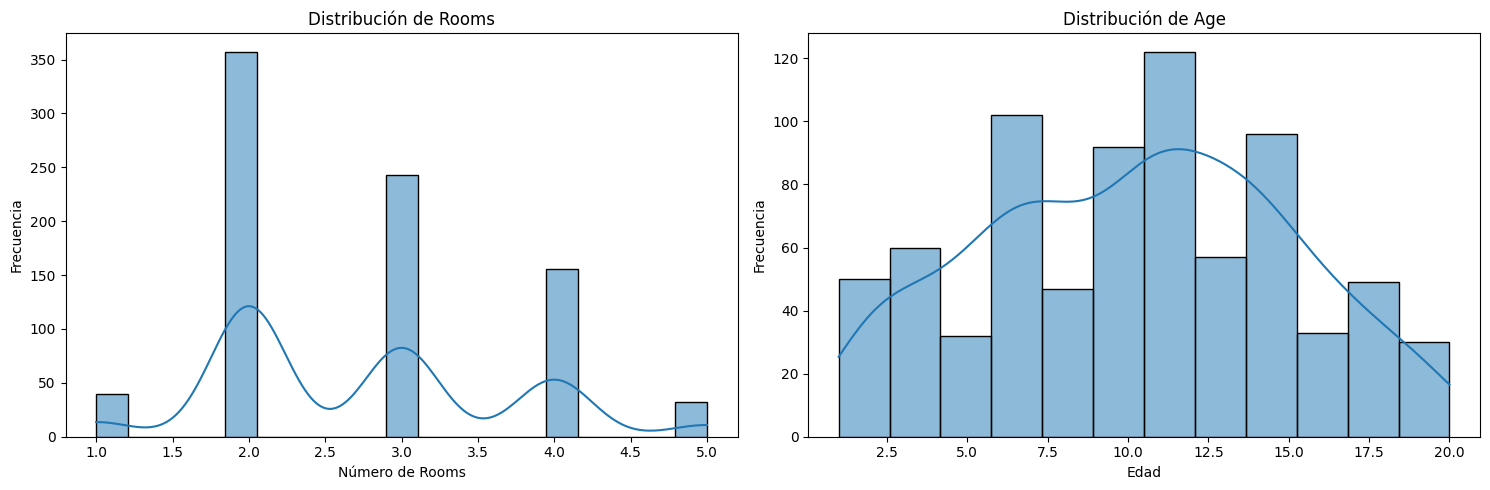

In [32]:
import seaborn as sns

import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 2, figsize=(15, 5))

sns.histplot(df['rooms'], kde=True, ax=axes[0])
axes[0].set_title('Distribución de Rooms')
axes[0].set_xlabel('Número de Rooms')
axes[0].set_ylabel('Frecuencia')

sns.histplot(df['age'], kde=True, ax=axes[1])
axes[1].set_title('Distribución de Age')
axes[1].set_xlabel('Edad')
axes[1].set_ylabel('Frecuencia')

plt.tight_layout()
plt.show()

Observamos que la media de ```roooms``` es ```2.737``` y que la media de ```age``` es ```10.212```. Podemos reemplazar en las muestras (filas) que tienen ```NaNs``` con la media. Esto es un proceso válido ya que al reemplazar los NaNs con la media, la variable conserva su escala original (no se generan valores fuera de rango ni se produce un sesgo), lo que ayuda a mantener la consistencia de la información que aporta esa variable.

Sin embargo, no estamos teniendo en cuenta que nuestros datos pueden estar agrupados en diferentes grupos. Momentareamente dejaré esta media insertada en los datos faltantes, pero cabe recalcar que está MAL, puesto que estamos agarrando el promedio de TODOS los grupos de datos que se presentan. A motivos de hacer este TP que siga con el enunciado, se realizaran las modificaciones en el inciso 4. 

Otra solución sería utilizar un modelo NO LINEAL para predecir estas features.

In [33]:

features_to_impute = ['rooms', 'age']


for feature in features_to_impute:

    mean_value = df[feature].mean()
    
    df[feature] = df[feature].fillna(mean_value)
    
    print(f'Imputando en {feature} con la media: {mean_value}')
    

print(df.head())

Imputando en rooms con la media: 2.7379227053140096
Imputando en age con la media: 10.212987012987012
         area  is_house  has_pool   age  price        lat        lon  rooms
0   58.993405         1         0  18.0  546.0  40.679064 -74.007844    2.0
1  102.007494         0         0   9.0  759.0  40.712839 -73.967750    3.0
2   61.966301         0         0   7.0  464.0  40.669863 -74.029414    2.0
3  127.000000         1         1  16.0  251.0 -34.600437 -58.415266    4.0
4  128.020334         0         0   8.0  963.0  40.722322 -73.983229    4.0


Guardamos el dataframe en un CSV.

In [34]:
df.to_csv(r"../data/processed/casas_dev.csv", index=False)

## Punto 1.2 <a id="punto-1-2"></a>



<div style="padding: 10px; border-radius: 5px;">
    <p>
        Realice una serie de histogramas y diagramas de dispersión (scatterplots) para mostrar
        la relación entre las variables. Para esto, es útil el comando <code>pairplot</code>. 
        ¿Qué conclusiones puede extraer a simple vista acerca de las relaciones entre las variables? 
        Se permite la creación de gráficos adicionales que considere relevantes.
    </p>
</div>


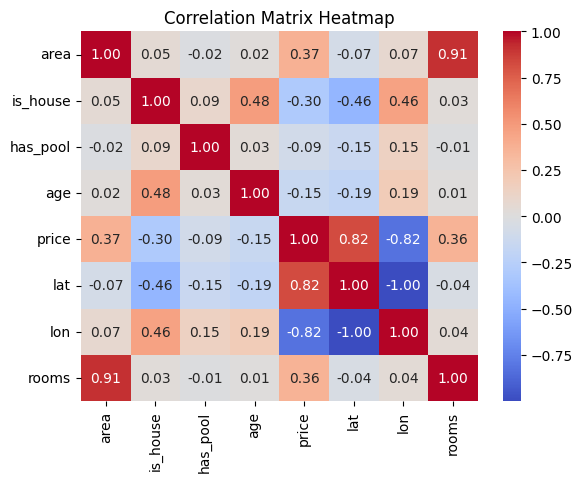

,area,is_house,has_pool,age,price,lat,lon,rooms
area,1.000000,0.047767,-0.020012,0.020607,0.371862,-0.071974,0.071787,0.907964
is_house,0.047767,1.000000,0.093175,0.482947,-0.298412,-0.459865,0.459664,0.029574
has_pool,-0.020012,0.093175,1.000000,0.033317,-0.088624,-0.146234,0.146399,-0.007955
age,0.020607,0.482947,0.033317,1.000000,-0.149007,-0.194795,0.194773,0.013094
price,0.371862,-0.298412,-0.088624,-0.149007,1.000000,0.822490,-0.822537,0.359635
lat,-0.071974,-0.459865,-0.146234,-0.194795,0.822490,1.000000,-0.999992,-0.040040
lon,0.071787,0.459664,0.146399,0.194773,-0.822537,-0.999992,1.000000,0.039892
rooms,0.907964,0.029574,-0.007955,0.013094,0.359635,-0.040040,0.039892,1.000000


In [35]:
import seaborn as sns 


# show the correlation matrix
corr = df.corr()
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix Heatmap')
plt.show()

corr

Observamos que la variable **area** presenta una correlación muy alta de 0.91 con **rooms**, lo que es totalmente coherente, ya que a medida que aumenta la cantidad de habitaciones, la superficie total de la propiedad tiende a crecer. Además, la **latitud (lat)** muestra una fuerte correlación positiva de 0.82 con **price**, lo que sugiere que las propiedades ubicadas en zonas con mayor latitud tienden a tener precios más altos; en contraposición, la **longitud (lon)** tiene una correlación negativa de -0.82 con **price**, lo que indica que en las áreas donde la longitud es mayor, los precios son más bajos. Esto podría interpretarse como que existen zonas geográficas diferenciadas, donde la posición en el mapa influye significativamente en el valor de la propiedad. 

Por otro lado, se observa una correlación moderada de 0.48 entre **is_house** y **age**, lo que sugiere que las casas (frente a otros tipos de propiedades) tienden a ser más antiguas. Asimismo, **is_house** se relaciona moderadamente con las coordenadas: presenta una correlación de -0.46 con **lat** y de 0.46 con **lon**, lo que puede indicar que las casas se concentran en áreas geográficas específicas distintas a aquellas de otros inmuebles. 

Finalmente, resulta destacable la casi perfecta correlación negativa de -1.0 entre **lat** y **lon**, lo que implica que, dentro del rango de datos, a medida que aumenta la latitud, la longitud disminuye de forma casi lineal, reflejando probablemente una distribución geográfica particular de las propiedades. Estos patrones nos ayudan a entender que la ubicación y el tipo de inmueble son determinantes importantes en la configuración del precio y otras características de las viviendas en el dataset.

puedo hacer lo que decia robbie de has_pool * is_house etc.

Podriamos clasificar las casas por zonas (clusters)

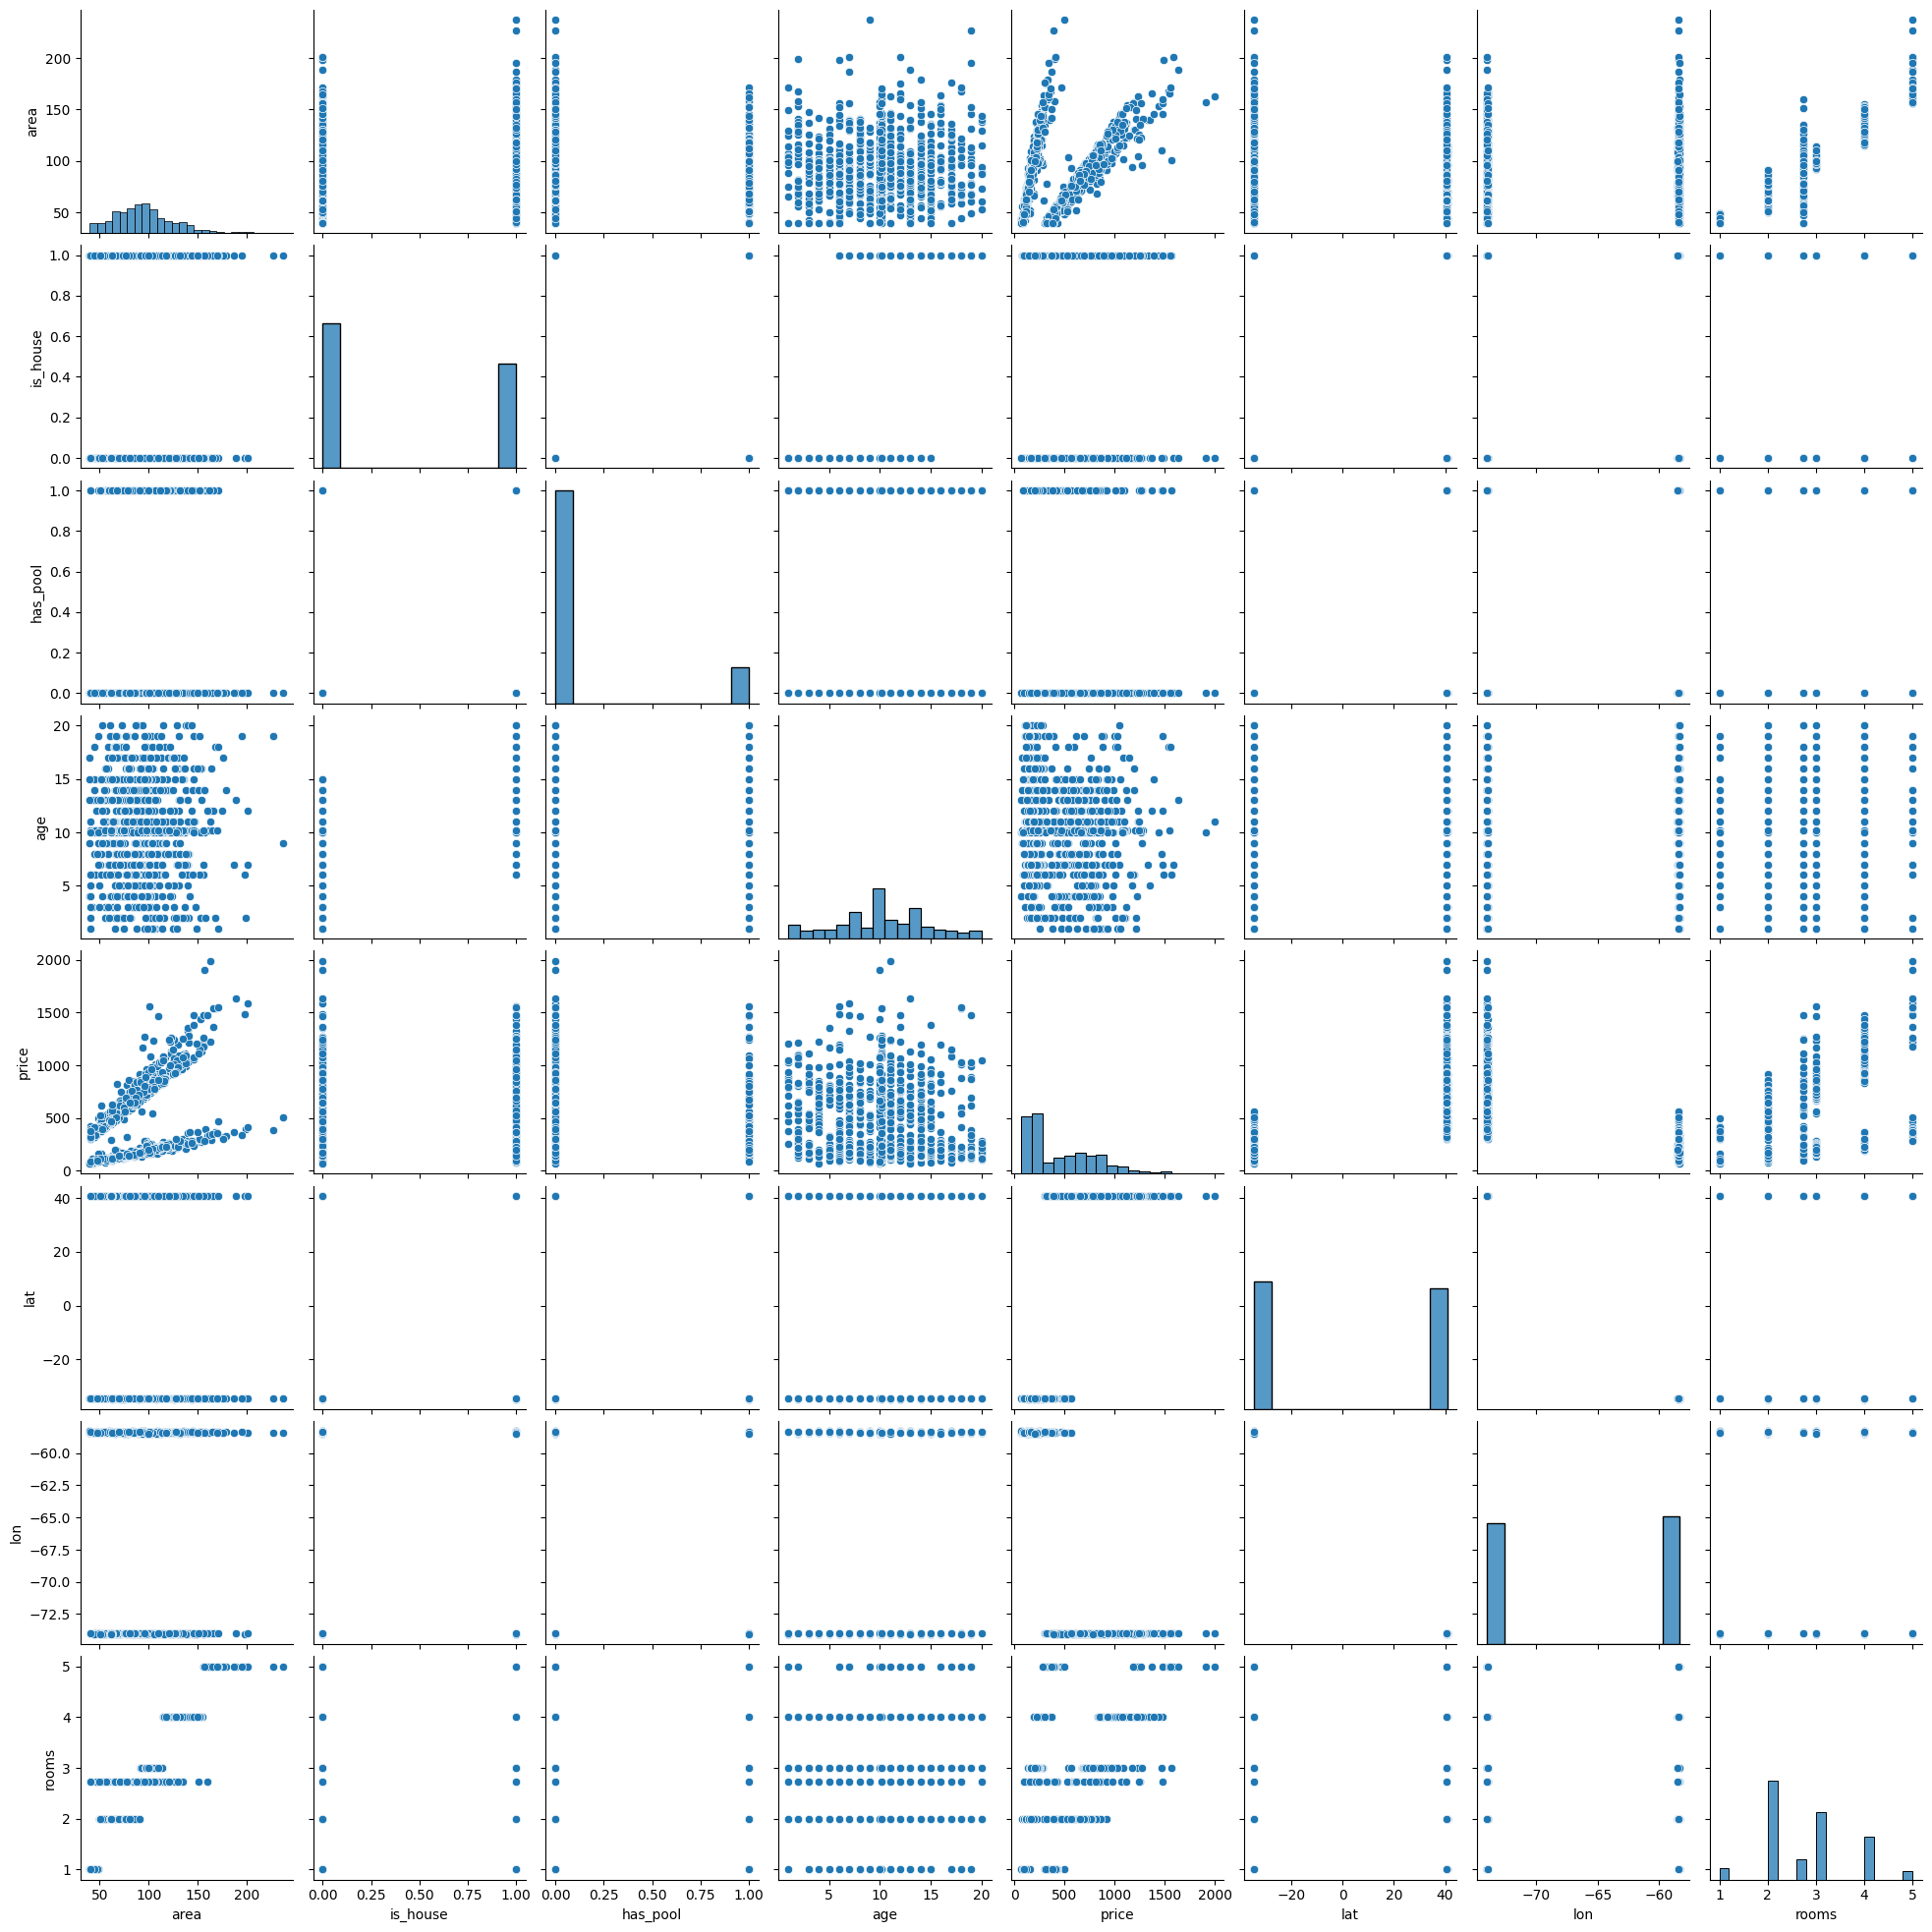

In [36]:
sns.pairplot(df)
plt.show()

## Punto 1.3 <a id="punto-1-3"></a>


Divida el conjunto de desarrollo casas_dev.csv en un 80 % para entrenamiento (train)
y un 20 % para validación (validation). Estos conjuntos se utilizarán para entrenar y
validar los modelos que desarrollarán en las siguientes secciones. Se sugiere normalizar
los datos para lograr un mejora el condicionamiento numérico de los algortmos de
aprendizaje. Recuerde que si normaliza los datos, cuando haga una predicción deberá
invertir la normalización para volver a las escalas originales.

In [37]:

from models.regression.data import split_test_train_with_label

df = pd.read_csv(r"../data/processed/casas_dev.csv")

X = df.drop('price', axis=1)
y = df['price']

y = np.log(y)

X_train, X_test, y_train, y_test = split_test_train_with_label(X, y, test_size=0.2, random_state=12)


# Punto 2

### Todas las features (menos price)

#### Pseudo Inversa

In [ ]:
from utils import train_and_evaluate_model
from models.regression.linear_regressor import LinearRegressor

results_linear_psinv_all = train_and_evaluate_model( # si no aplico log a y, el modelo es malisimo
    data_path=r"../data/processed/casas_dev.csv",
    target_column="price",
    test_size=0.20,
    random_state=12,
    transform_target=None,
    model_class=LinearRegressor,
    normalize_features=False,
    fit_params={'method': "pseudo_inverse"},
    metrics=['mse', 'r2', 'mae']
)

model_linear_psinv_all = results_linear_psinv_all["model"]



=== Model Evaluation (LinearRegressor) ===
MSE: 11630.160150
R2: 0.904712
MAE: 83.190651
Método: pseudo_inverse
Intercept: 3677.5350

Coeficientes:
------------------------------
area            | +4.9952
is_house        | +75.3474
has_pool        | +43.4141
age             | -3.4354
lat             | +19.9893
lon             | +56.3301
rooms           | -3.9214


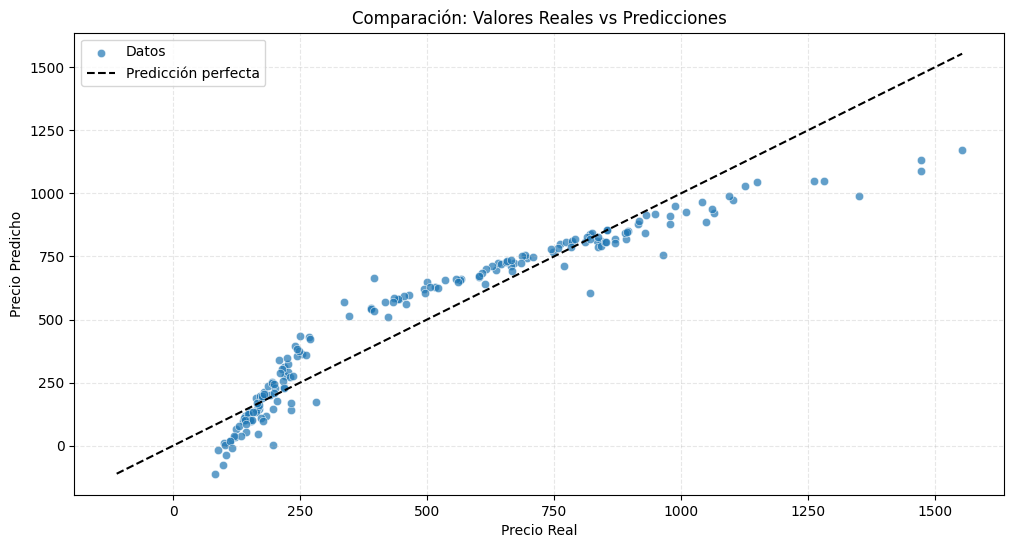

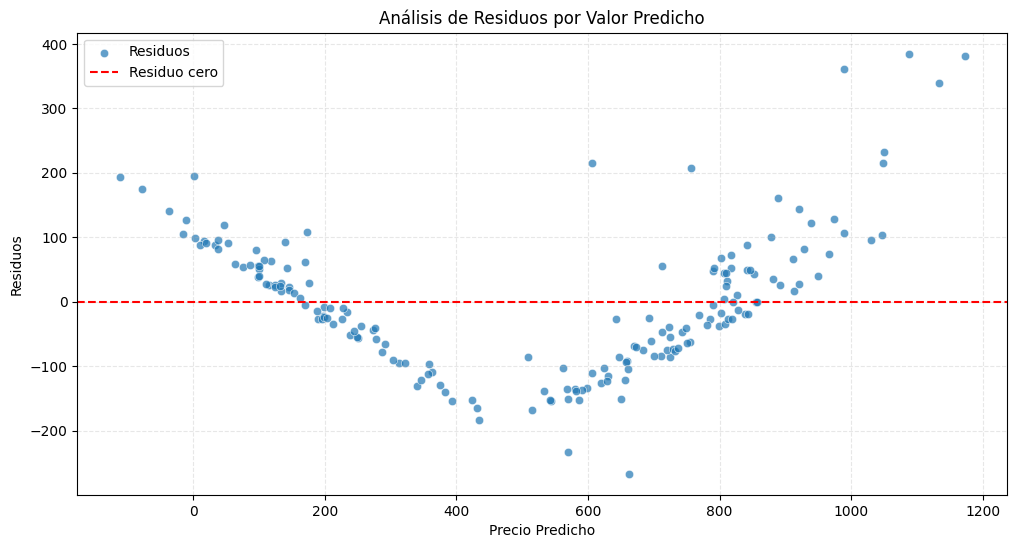

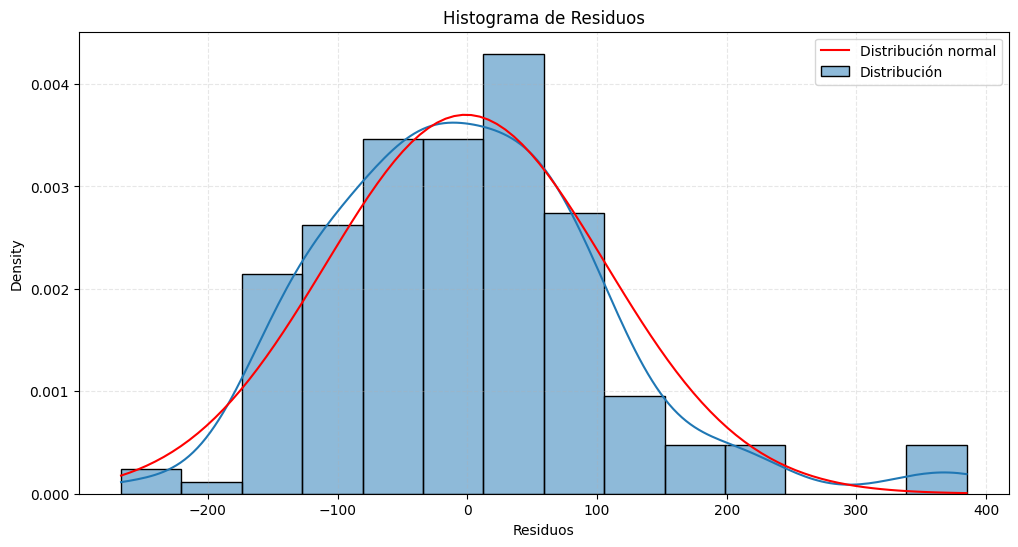

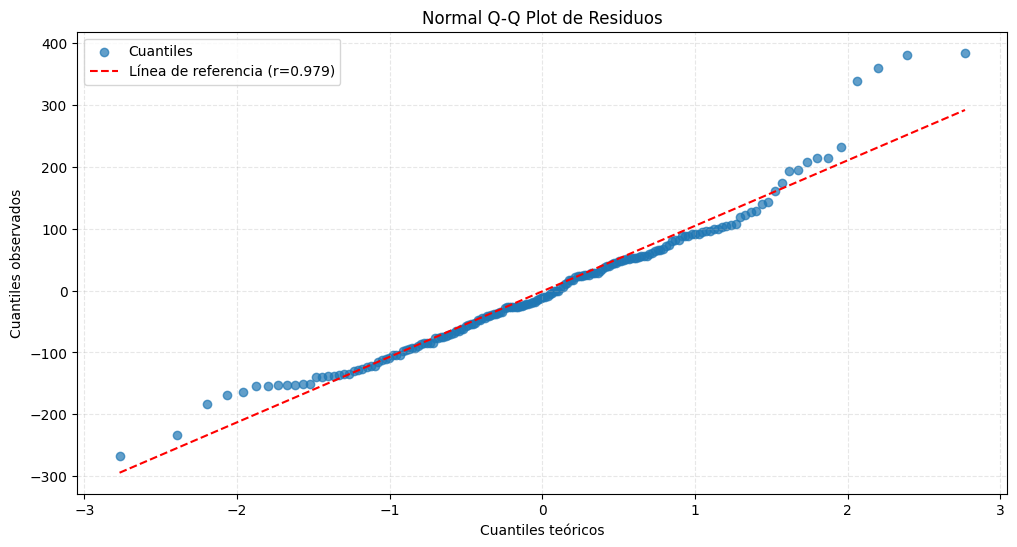

In [39]:
from utils import visualize_regression_results

custom_titles = {
    "scatter": "Comparación: Valores Reales vs Predicciones",
    "residuals": "Análisis de Residuos por Valor Predicho",
    "distribution": "Histograma de Residuos"
}


figures_linear_psinv_all = visualize_regression_results(
    results_linear_psinv_all['y_test'],
    results_linear_psinv_all['y_pred_test'],
    transform_func=None,
    fig_size=(12, 6),
    titles=custom_titles,
    show_figures=True
)



Los gráficos muestran, en el diagrama de residuos vs. valores predichos, que la varianza de los errores no se mantiene constante a lo largo de todo el rango de valores y se observa cierta curvatura que sugiere una relación no capturada por el modelo o heterocedasticidad. Al mismo tiempo, el Q-Q plot (con distribución normal) indica que, en general, los residuos se aproximan a la distribución normal, aunque se aprecian leves desvíos que podría deberse a la presencia de outliers. El histograma de residuos confirma que la mayoría se concentra cerca de cero pero existen valores atípicos que se extienden hacia la cola positiva. Conviene revisar si el modelo está capturando adecuadamente la forma funcional de las variables, por ejemplo, incluyendo términos polinómicos o interacciones en caso de relaciones no lineales. Ridge o Lasso pueden ayudar si hay multicolinealidad o sobreajuste, ya que estabilizan los coeficientes y reducen la varianza de las estimaciones, pero no resuelven de manera directa la heterocedasticidad. 

Estaría bueno hacer tests de heterocedasticidad.

Probamos un modelo polinómico de 4to orden para ver si podemos capturar estas relaciones.

In [40]:
from models.regression.polinomial_regressor import PolinomialRegressor

results_4d_psinv_all = train_and_evaluate_model(
    data_path=r"../data/processed/casas_dev.csv",
    target_column="price",
    test_size=0.20,
    random_state=12,
    transform_target=np.log,
    model_class=PolinomialRegressor.change_degree(4),
    normalize_features=False,
    fit_params={'method': "pseudo_inverse"},
    metrics=['mse', 'r2', 'mae']
)

model_4d_psinv_all = results_4d_psinv_all["model"]



=== Model Evaluation (PolinomialRegressor) ===
MSE: 0.008805
R2: 0.985388
MAE: 0.069597
Método: pseudo_inverse
Intercept: -0.0475

Coeficientes:
------------------------------
area            | +0.0372
is_house        | +0.0308
has_pool        | +0.0280
age             | +0.0009
lat             | -86.1064
lon             | +1.0997
rooms           | -0.1537
area^2          | -0.0003
is_house^2      | +0.0308
has_pool^2      | +0.0280
age^2           | -0.0013
lat^2           | +13.0483
lon^2           | -13.6672
rooms^2         | +0.1435
area^3          | +0.0000
is_house^3      | +0.0308
has_pool^3      | +0.0280
age^3           | +0.0000
lat^3           | +0.0586
lon^3           | -0.2795
rooms^3         | -0.0433
area^4          | -0.0000
is_house^4      | +0.0308
has_pool^4      | +0.0280
age^4           | +0.0000
lat^4           | -0.0047
lon^4           | -0.0016
rooms^4         | +0.0043


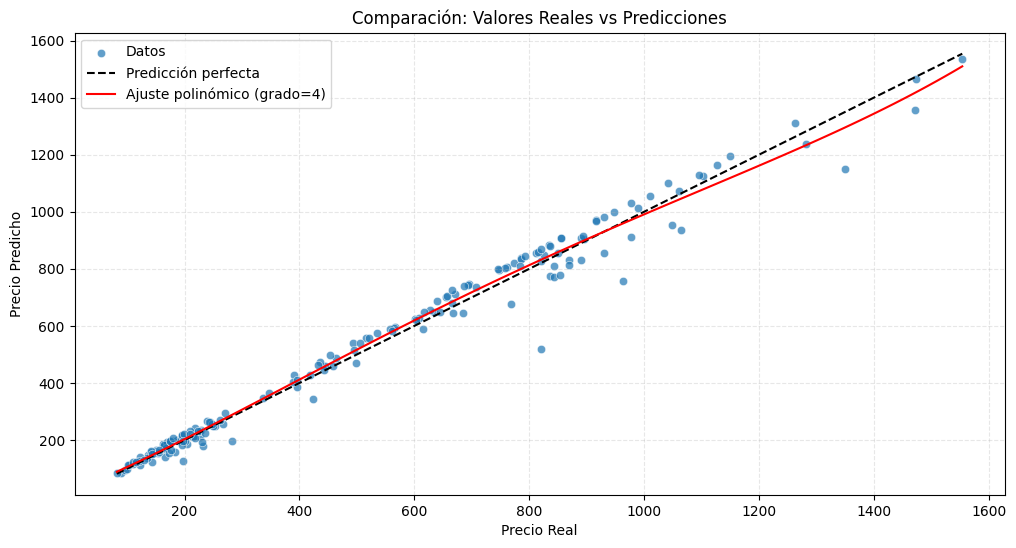

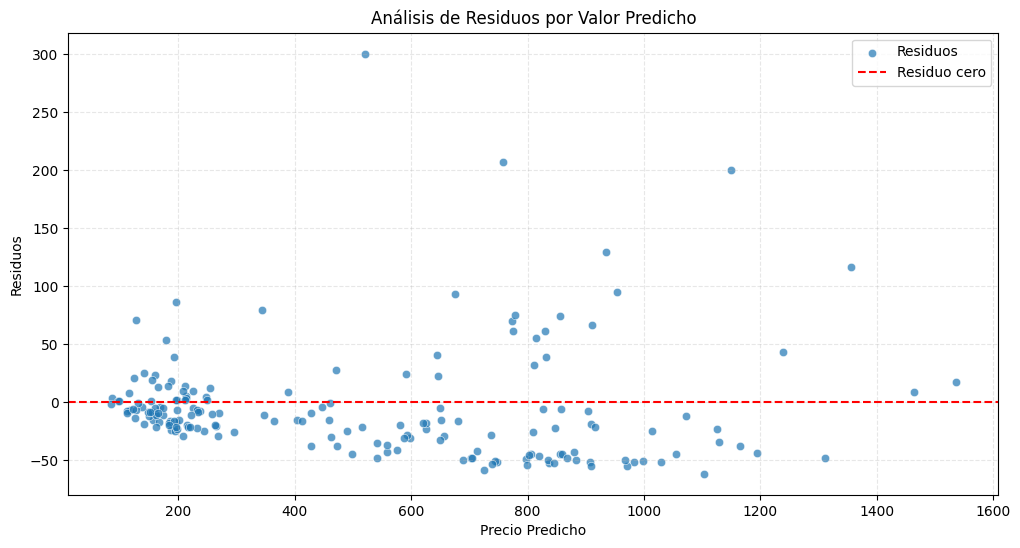

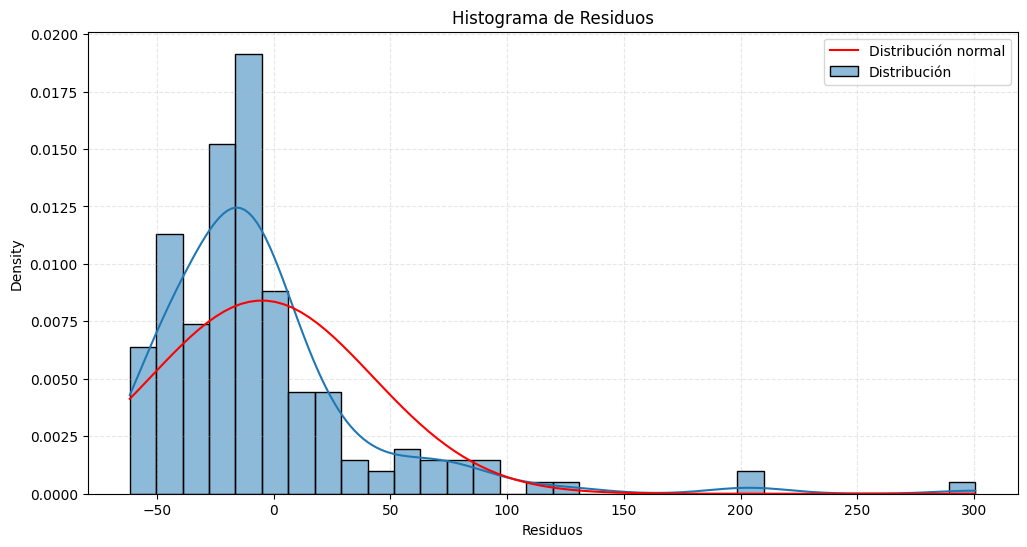

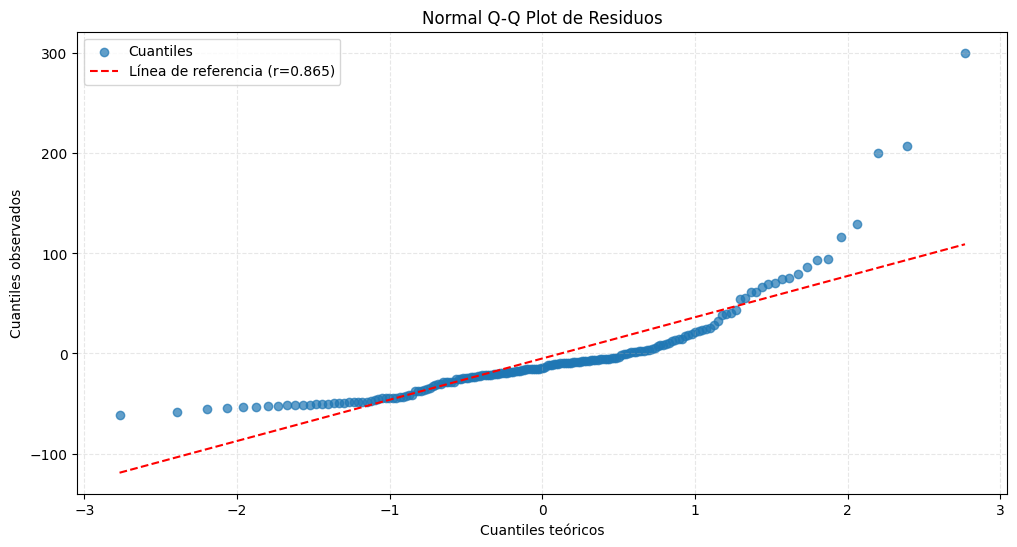

In [41]:
from utils import visualize_regression_results

custom_titles = {
    "scatter": "Comparación: Valores Reales vs Predicciones",
    "residuals": "Análisis de Residuos por Valor Predicho",
    "distribution": "Histograma de Residuos"
}


figures_2d_psinv_all = visualize_regression_results(
    results_4d_psinv_all['y_test'],
    results_4d_psinv_all['y_pred_test'],
    transform_func=np.exp,
    fig_size=(12, 6),
    titles=custom_titles,
    show_figures=True,
    fit_degree=4
)



#### Gradient Descent

In [42]:
from utils import train_and_evaluate_model
from models.regression.linear_regressor import LinearRegressor

results_gd_linear_all = train_and_evaluate_model(
    data_path=r"../data/processed/casas_dev.csv",
    target_column="price",
    test_size=0.20,
    random_state=12,
    model_class=LinearRegressor,
    transform_target=np.log,
    normalize_features=True,
    fit_params={'method': 'gradient_descent',
                "epochs": 1000,
                "learning_rate":0.01
                },
    metrics=['mse', 'r2', 'mae']
    )

model_gd_linear_all = results_gd_linear_all["model"]



=== Model Evaluation (LinearRegressor) ===
MSE: 0.013212
R2: 0.978073
MAE: 0.082001
Método: gradient_descent
Intercept: 5.8310

Coeficientes:
------------------------------
area            | +0.2612
is_house        | +0.0513
has_pool        | +0.0401
age             | -0.0349
lat             | +0.3685
lon             | -0.3688
rooms           | +0.0593

R^2 final: 0.9600
Convergencia: Sí
Iteraciones: 738/1000


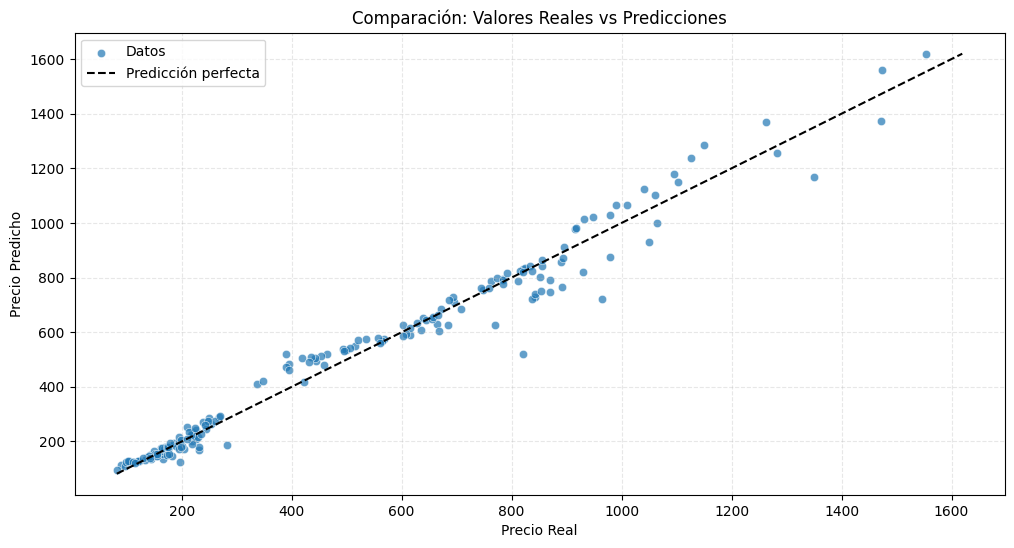

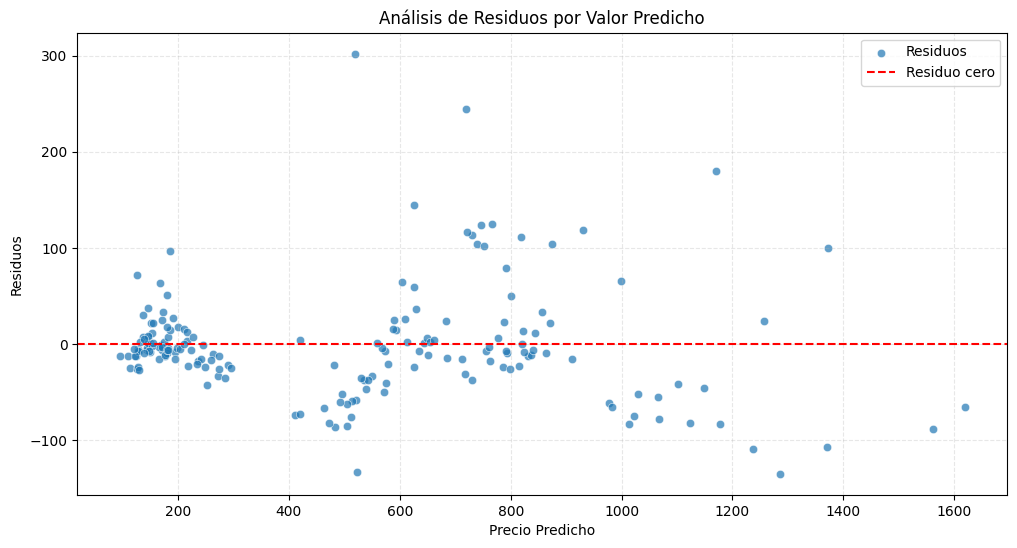

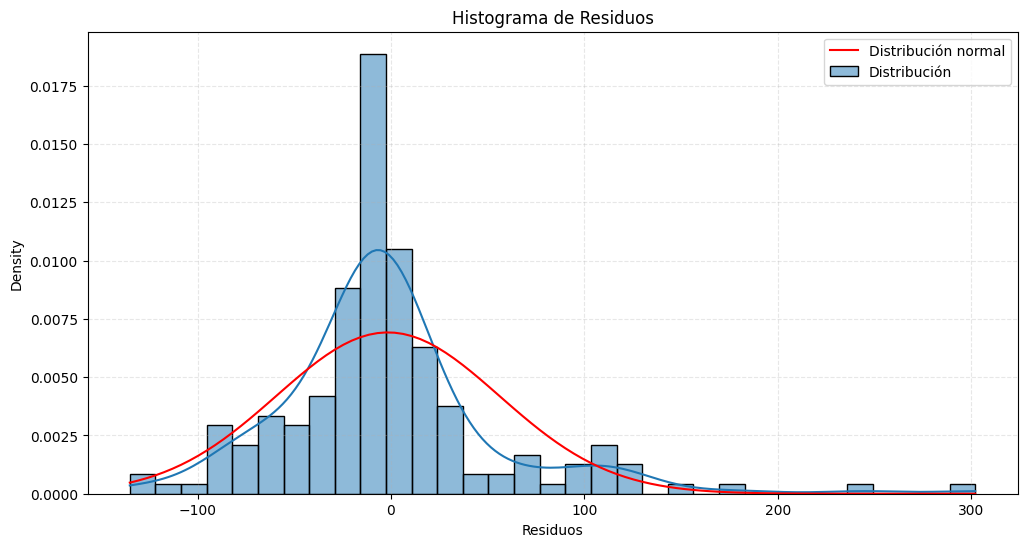

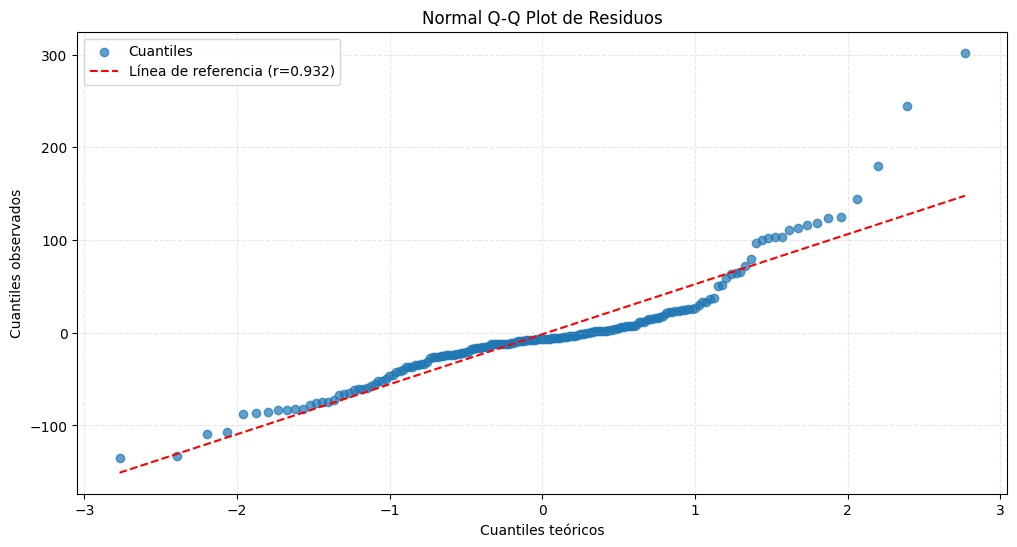

In [43]:
from utils import visualize_regression_results

custom_titles = {
    "scatter": "Comparación: Valores Reales vs Predicciones",
    "residuals": "Análisis de Residuos por Valor Predicho",
    "distribution": "Histograma de Residuos"
}

figures = visualize_regression_results(
    results_gd_linear_all['y_test'],
    results_gd_linear_all['y_pred_test'],
    transform_func=np.exp,
    fig_size=(12, 6),
    titles=custom_titles,
    show_figures=True,
    fit_degree=1
)





### 1 feature


Pseudo Inversa

In [44]:
from utils import train_and_evaluate_model

results_linear_psinv_area = train_and_evaluate_model( 
    data_path=r"../data/processed/casas_dev.csv",
    target_column="price",
    test_size=0.20,
    random_state=12,
    feature_columns = ["area"],
    model_class=LinearRegressor,
    transform_target=None,
    normalize_features=False,
    fit_params={'method': 'pseudo_inverse'},
    metrics=['mse', 'r2', 'mae']
)

model_linear_psinv_area = results_linear_psinv_area["model"]


=== Model Evaluation (LinearRegressor) ===
MSE: 102728.297632
R2: 0.158327
MAE: 296.621040
Método: pseudo_inverse
Intercept: 75.5102

Coeficientes:
------------------------------
area            | +4.0167


Gradient descent


In [45]:
from utils import train_and_evaluate_model

results_gd_linear_area = train_and_evaluate_model( # si no transformo el target usando log, da muy alto el mse
    data_path=r"../data/processed/casas_dev.csv",
    target_column="price",
    test_size=0.20,
    random_state=12,
    model_class=LinearRegressor,
    feature_columns = ["area"],
    normalize_features=True,
    fit_params={'method': 'gradient_descent',
                "epochs": 1000,
                "learning_rate":0.01
                },
    metrics=['mse', 'r2', 'mae'],
    verbose=True
)

model_gd_linear_area = results_gd_linear_area["model"]



=== Model Evaluation (LinearRegressor) ===
MSE: 102728.866581
R2: 0.158322
MAE: 296.621513
Método: gradient_descent
Intercept: 455.7119

Coeficientes:
------------------------------
area            | +123.4822

R^2 final: 0.1275
Convergencia: Sí
Iteraciones: 569/1000


# Punto 3

## Punto 3.1

In [46]:
model_linear_psinv_area.print_coefficients()


Método: pseudo_inverse
Intercept: 75.5102

Coeficientes:
------------------------------
area            | +4.0167

MSE final: 104161.1444


### Punto 3.2

In [47]:
import pandas as pd
import numpy as np

df_amanda = pd.read_csv(r"../vivienda_Amanda.csv")

df_amanda.loc[df_amanda['area_units'] == 'sqft', 'area'] = df_amanda['area'] * 0.092903
df_amanda['area_units'] = 'm2'  

df_amanda = df_amanda.drop('area_units', axis=1)


print(f"Model features: {model_4d_psinv_all.feature_names}")


# si normalice:
# df_amanda = (df_amanda - X_train.mean()) / X_train.std()

y_pred = model_4d_psinv_all.predict(df_amanda)

y_pred_original = np.exp(y_pred)
print(f"Predicted price a: {y_pred_original[0]:.2f}")


Model features: ['area', 'is_house', 'has_pool', 'age', 'lat', 'lon', 'rooms', 'area^2', 'is_house^2', 'has_pool^2', 'age^2', 'lat^2', 'lon^2', 'rooms^2', 'area^3', 'is_house^3', 'has_pool^3', 'age^3', 'lat^3', 'lon^3', 'rooms^3', 'area^4', 'is_house^4', 'has_pool^4', 'age^4', 'lat^4', 'lon^4', 'rooms^4']
Predicted price a: 790.78


### Punto 3.3

3.3) En el dataset, ¿cuál es el valor promedio por metro cuadrado de una casa

peso de la regresión no normalizada

si lo normalice a cada putno lo desnormalizo

In [48]:
from utils import train_and_evaluate_model, visualize_regression_results

df = pd.read_csv(r"../data/processed/casas_dev.csv")
df = df[df["is_house"] == 1]

results_area = train_and_evaluate_model( 
    df = df,
    target_column="price",
    test_size=0.20,
    random_state=12,
    feature_columns = ["area"],
    model_class=LinearRegressor,
    transform_target=None,
    normalize_features=False,
    fit_params={'method': 'pseudo_inverse'},
    metrics=['mse', 'r2', 'mae']
)

model_area = results_area["model"]


coef = model_area.get_coef_dict()

area_cof = coef["area"]


print(f"El valor promedio por metro cuadrado de una casa es: {area_cof:.2f}")

# figures_area = visualize_regression_results(
#     results_area['y_test'],
#     results_area['y_pred_test'],
#     transform_func=np.exp,
#     fig_size=(12, 6),
#     titles=custom_titles,
#     show_figures=True,
#     fit_degree=1
# )


=== Model Evaluation (LinearRegressor) ===
MSE: 90594.214090
R2: 0.075942
MAE: 232.550763
Método: pseudo_inverse
Intercept: 0.4477

Coeficientes:
------------------------------
area            | +3.6400
El valor promedio por metro cuadrado de una casa es: 3.64


### Punto 3.4

Benito está evaluando la posibilidad de construir una pileta. ¿Cómo afectaría la construcción de una pileta al precio de su propiedad? Explique cómo llegó a este resultado.

In [49]:
# Benito está evaluando la posibilidad de construir una pileta. ¿Cómo afectaría la construcción de una pileta al precio de su propiedad? Explique cómo llegó a este resultado.

df = pd.read_csv(r"../data/processed/casas_dev.csv")    

precios = df.groupby('has_pool')['price'].mean()
print(precios)


has_pool
0    478.831169
1    391.369231
Name: price, dtype: float64


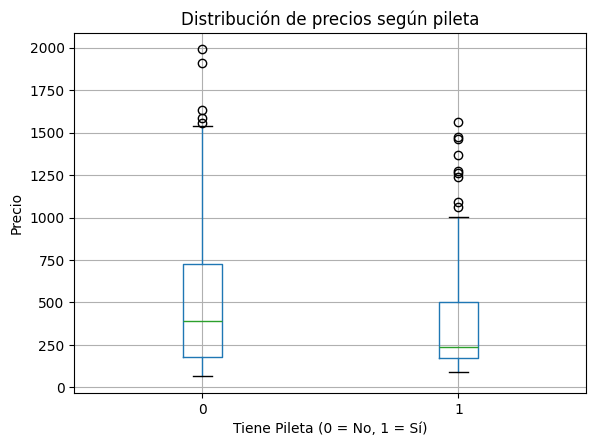

In [50]:
import matplotlib.pyplot as plt

df.boxplot(column='price', by='has_pool')
plt.title('Distribución de precios según pileta')
plt.suptitle('')
plt.xlabel('Tiene Pileta (0 = No, 1 = Sí)')
plt.ylabel('Precio')
plt.show()

In [51]:
model_4d_psinv_all.print_coefficients()


Método: pseudo_inverse
Intercept: -0.0475

Coeficientes:
------------------------------
area            | +0.0372
is_house        | +0.0308
has_pool        | +0.0280
age             | +0.0009
lat             | -86.1064
lon             | +1.0997
rooms           | -0.1537
area^2          | -0.0003
is_house^2      | +0.0308
has_pool^2      | +0.0280
age^2           | -0.0013
lat^2           | +13.0483
lon^2           | -13.6672
rooms^2         | +0.1435
area^3          | +0.0000
is_house^3      | +0.0308
has_pool^3      | +0.0280
age^3           | +0.0000
lat^3           | +0.0586
lon^3           | -0.2795
rooms^3         | -0.0433
area^4          | -0.0000
is_house^4      | +0.0308
has_pool^4      | +0.0280
age^4           | +0.0000
lat^4           | -0.0047
lon^4           | -0.0016
rooms^4         | +0.0043

MSE final: 0.0181


El coeficiente para “has_pool” es +0.1173, lo que significa que, manteniendo constantes todas las demás variables del modelo (área, tipo de propiedad, edad, ubicación y número de habitaciones), la presencia de una pileta se asocia, en promedio, con un aumento de 0.1173 unidades en el precio de la propiedad.

# Punto 4

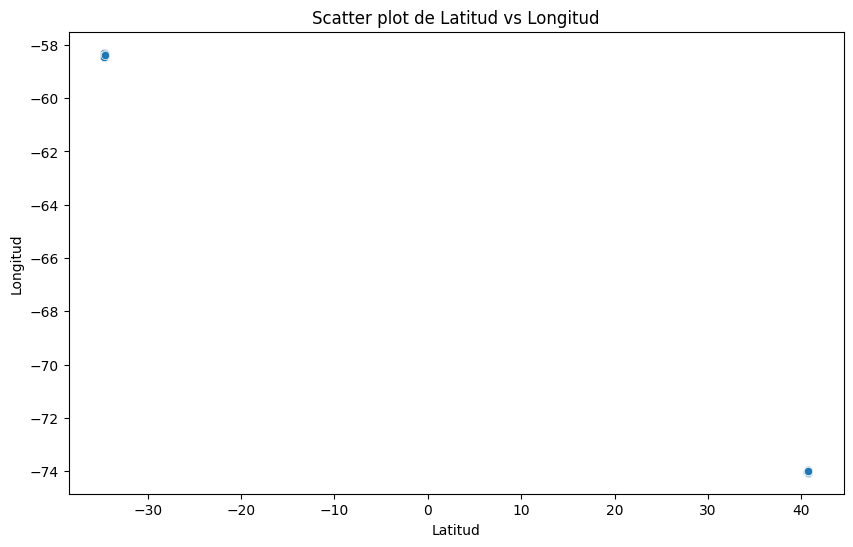

In [52]:
# scatter plot de 'lat' vs 'lon'
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x='lat', y='lon')
plt.title('Scatter plot de Latitud vs Longitud')
plt.xlabel('Latitud')
plt.ylabel('Longitud')
plt.show()

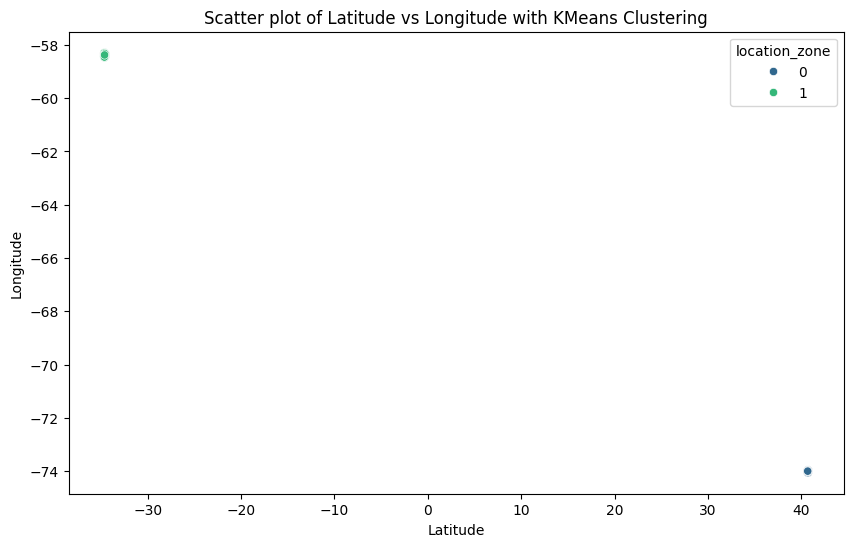

In [53]:
import numpy as np
from models.clustering.kmeans import KMeans
import matplotlib.pyplot as plt
import seaborn as sns

# Convert DataFrame columns to numpy array
X = df[['lat', 'lon']].to_numpy()

# Create KMeans object
kmeans = KMeans(n_clusters=2)

# Train the model
kmeans.fit(X)

# Get cluster labels
df['location_zone'] = kmeans.predict(X)

# Create scatter plot
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x='lat', y='lon', hue='location_zone', palette='viridis')
plt.title('Scatter plot of Latitude vs Longitude with KMeans Clustering')
plt.xlabel('Latitude')
plt.ylabel('Longitude')
plt.show()

# FINAL

In [54]:
df = pd.read_csv(r"../data/raw/casas_test.csv")

df.loc[df['area_units'] == 'sqft', 'area'] = df['area'] * 0.092903
df.loc[df['area_units'] == 'sqft', 'area_units'] = 'm2'

df = df.drop('area_units', axis=1)

df.to_csv(r"../data/processed/casas_test.csv", index=False)

# predict with model_4d_psinv_all

X_test = df.drop('price', axis=1)
y_test = df['price']

y_test = np.log(y_test)

y_pred_test = model_4d_psinv_all.predict(X_test)
y_pred_test = np.exp(y_pred_test)

r2 = model_4d_psinv_all.r2_score(X_test, y_test)
print("R² Score:", r2)

R² Score: 0.9395797881167027
